# Segmentation of COVID-19 X-ray Images

COVID-QU-Ex Dataset

In [ ]:

!pip install kagglehub torch torchvision opencv-python matplotlib scikit-learn


In [ ]:

import kagglehub
path = kagglehub.dataset_download("anasmohammedtahir/covidqu")
print(path)


Using Colab cache for faster access to the 'covidqu' dataset.
/kaggle/input/covidqu


In [ ]:
import torch
torch.backends.cudnn.benchmark = True


## Dataset Exploration

In [ ]:

import os

for root, dirs, files in os.walk(path):
    print(root, len(files))
    break


/kaggle/input/covidqu 1


## Dataset Loader

In [ ]:

import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class CovidDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.imgs = sorted(os.listdir(img_dir))
        self.img_dir = img_dir
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.img_dir, self.imgs[idx]), 0)
        mask = cv2.imread(os.path.join(self.mask_dir, self.imgs[idx]), 0)
        img = cv2.resize(img, (256,256)) / 255.0
        mask = cv2.resize(mask, (256,256)) / 255.0
        return torch.tensor(img).unsqueeze(0).float(), torch.tensor(mask).unsqueeze(0).float()


## U-Net Model

In [ ]:

import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(1,64,3,1,1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(64,128,3,2,1), nn.ReLU())
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(128,64,2,2), nn.ReLU())
        self.out = nn.Conv2d(64,1,1)

    def forward(self,x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.dec1(x2)
        return torch.sigmoid(self.out(x3))


## Training

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
loss_fn = nn.BCELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:

img_dir = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images"
mask_dir = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/infection masks"
ds = CovidDataset(img_dir, mask_dir)
dl = DataLoader(ds, batch_size=4, shuffle=True)

for epoch in range(3):
    for x,y in dl:
        x,y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(epoch, loss.item())


0 0.2997494041919708
1 0.23987215757369995
2 0.32746267318725586


# Validation & Test dataset

In [ ]:
val_img_dir = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/COVID-19/images"
val_mask_dir = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/COVID-19/infection masks"

test_img_dir = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images"
test_mask_dir = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/infection masks"

train_ds = CovidDataset(img_dir, mask_dir)
val_ds   = CovidDataset(val_img_dir, val_mask_dir)
test_ds  = CovidDataset(test_img_dir, test_mask_dir)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=4, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=4, shuffle=False)


In [ ]:
for epoch in range(3):
    model.train()
    train_loss = 0.0

    for x, y in train_dl:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item()

    train_loss /= len(train_dl)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            val_loss += loss.item()

    val_loss /= len(val_dl)

    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


Epoch 0: Train Loss = 0.3503, Val Loss = 0.3438
Epoch 1: Train Loss = 0.3498, Val Loss = 0.3434
Epoch 2: Train Loss = 0.3494, Val Loss = 0.3425


In [ ]:
# Test validation
model.eval()
test_loss = 0.0

with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        test_loss += loss.item()

test_loss /= len(test_dl)
print("Test Loss:", test_loss)


Test Loss: 0.3440450447267049


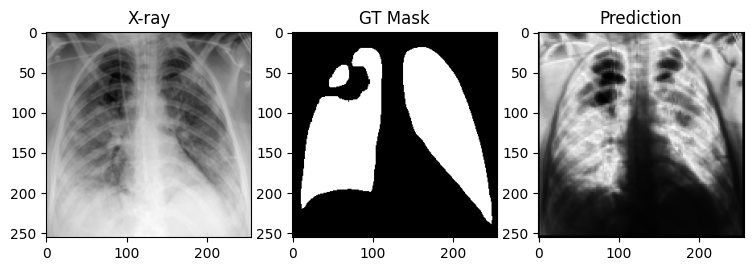

In [ ]:
# Visualize
import matplotlib.pyplot as plt

x, y = test_ds[0]
with torch.no_grad():
    p = model(x.unsqueeze(0).to(device)).cpu().squeeze()

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(x.squeeze(), cmap="gray"); plt.title("X-ray")
plt.subplot(1,3,2); plt.imshow(y.squeeze(), cmap="gray"); plt.title("GT Mask")
plt.subplot(1,3,3); plt.imshow(p, cmap="gray"); plt.title("Prediction")
plt.show()


## Evaluation

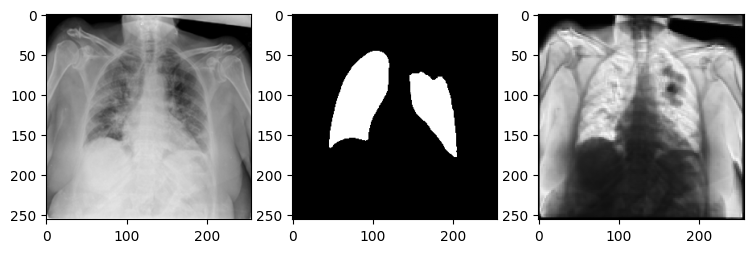

In [ ]:
# Evaluation train
import matplotlib.pyplot as plt

x,y = ds[0]
with torch.no_grad():
    p = model(x.unsqueeze(0).to(device)).cpu().squeeze().numpy()

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(x.squeeze(), cmap="gray")
plt.subplot(1,3,2); plt.imshow(y.squeeze(), cmap="gray")
plt.subplot(1,3,3); plt.imshow(p, cmap="gray")
plt.show()
